In [1]:
import os
#0, 1, 2, 3있음
#os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.models import load_model
import copy
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras import activations
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.metrics import Recall
from sklearn.metrics import confusion_matrix
import seaborn as sns
from PIL import Image
from tensorflow.keras import optimizers
from tensorflow.keras import activations
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow.keras.models import Model
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model

def functional_model(HEIGHT, WIDTH, outdim):
    # Define the input layer
    inputs = Input(shape=(HEIGHT, WIDTH, 3))

    # 첫번째 conv layer + pooling layer
    x = Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.1)(x)  # 드롭아웃 추가

    # 두번째 conv layer + pooling layer
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(0.1)(x)  # 드롭아웃 추가

    # 세번째 conv layer + pooling layer
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='gradlayer')(x)
    x = Dropout(0.1)(x)  # 드롭아웃 추가

    # Flatten the output
    x = Flatten()(x)

    # Dense layer with 512 units
    x = Dense(512)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    # Output layer with softmax activation
    outputs = Dense(outdim, activation='softmax')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [3]:
# project(i, initial_path, HEIGHT, WIDTH, outdim) i는 checkpoint, initial_path는 대오더라벨까지 저장하는 최상위 폴더, HEIGHT는 높이, WIDTH는 가로, outdim 은 타겟변수의 차원값.

class project:
    def __init__(self, i, initial_path, HEIGHT, WIDTH, outdim, epochs):
        self.HEIGHT, self.WIDTH, self.outdim = HEIGHT, WIDTH, outdim
        self.model = functional_model(self.HEIGHT, self.WIDTH, self.outdim)
        self.i = i
        self.epochs = epochs
        self.initial_path = initial_path
        self.early_stopping = EarlyStopping(monitor='val_loss',  # 모니터링할 지표 (여기서는 검증 손실)
                               patience=4,          # 지정된 횟수만큼 개선이 없을 경우 훈련 중단
                               restore_best_weights=True)
        # ImageDataGenerator 설정
        self.datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=5,
            height_shift_range=5,
            horizontal_flip=False,
            vertical_flip=False,
            fill_mode='nearest')
        # rotation 각도를 키우는 것이 주효함

    def data_loader(self, path, final_num):
                # 이미지 파일 확장자 (여기서는 jpg, jpeg, png로 가정)
        valid_image_extensions = ['.jpg', '.jpeg', '.png']

        # 해당 경로의 이미지 파일 목록 가져오기
        image_files = [f for f in os.listdir(path) if os.path.splitext(f)[1].lower() in valid_image_extensions]

        # 이미지를 저장할 리스트
        image_list = []

        # 각 이미지 파일에 대해 반복
        for image_file in image_files:
            # 이미지 파일 경로
            image_path = os.path.join(path, image_file)

            # 이미지 불러오기 (OpenCV를 사용하여)
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = image[580:1080, 50:350]
            image= cv2.resize(image, (128, 128))
            image_list.append(image) # cv2리스트


        # 이미지 리스트를 NumPy 배열로 변환하여 반환
            
        image_batch = copy.deepcopy(image_list)

        m = []
        for i in range(0, final_num-len(image_batch)):
            k = random.randint(0, len(image_batch)-1)
            m.append(k)

        image_batch_ = copy.deepcopy(image_batch)

        aug = []
        for i in m:
            img = image_batch_[i]
            img_augmented = self.datagen.random_transform(img)
            aug.append(img_augmented)

        all = image_batch + aug
        return all, image_batch, aug
        # 'image_batch' : 원본 / 'aug' : 증강된 데이터 / 'all' : 순서대로 원본+증강 
    def data_encoder(self, final_num_seal, final_num_unsealed):
        # os.listdir(self.initial_path)[0] # seal
        # os.listdir(self.initial_path)[1] # unsealed
        # 만약 image_batch_seal, aug_seal를 보고 싶으면 self를 붙이삼ㅋㅋ
        all_seal, image_batch_seal, aug_seal = self.data_loader(os.path.join(self.initial_path, os.listdir(self.initial_path)[0]), final_num_seal)
        all_unsealed, image_batch_unsealed, aug_unsealed = self.data_loader(os.path.join(self.initial_path, os.listdir(self.initial_path)[1]), final_num_unsealed)
        all_seal_np = np.array(all_seal)/255
        all_unsealed_np = np.array(all_unsealed)/255
        image_all = np.concatenate((all_seal_np, all_unsealed_np), axis=0)
        
        array_1 = np.array([[1, 0]] * final_num_seal)
        array_0 = np.array([[0, 1]] * final_num_unsealed)
        label_all = np.concatenate((array_1, array_0), axis=0)


        # 데이터를 훈련 세트(80%)와 테스트 세트(20%)로 나누기
        self.X_train, X_temp, self.y_train, y_temp = train_test_split(image_all, label_all, test_size=0.2224, random_state=42)

        # 나머지 데이터를 검증 세트(25%)와 테스트 세트(75%)로 나누기
        self.X_valid, self.X_test, self.y_valid, self.y_test = train_test_split(X_temp, y_temp, test_size=0.4995, random_state=42)
        
    def train(self):
        
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
        epoch = self.epochs
        batch_size = 64

        # validation_data 매개변수를 사용하여 검증 세트를 지정
        self.History = self.model.fit(self.X_train, self.y_train, epochs=epoch,
                            batch_size=batch_size, shuffle=True,
                            validation_data=(self.X_valid, self.y_valid), 
                            callbacks=[self.early_stopping],
                            verbose=1).history

        pass

    def confusion_matrix(self):
        pass

    def gradcam(self, img_array, last_conv_layer_name, pred_index=None):
            # 마지막 feature maps에 대한 모델의 미분을 계산하기 위해서
            # 마지막 feature maps과 모델을 최종 예측값을 동시에 출력하는 모델을 새롭게 정의한다.
            # 이것은 케라스 문법이기 때문에 익숙치 않을 수 있다. 
            #    - Model 함수의 첫 번째 인자는 입력 객체, 두 번째 인자는 출력 객체이다.
            #    - 마지막 feature maps과 최종 예측값 두 개를 출력한다.
            grad_model = tf.keras.models.Model(
                [self.model.inputs], [self.model.get_layer(last_conv_layer_name).output, self.model.output]
            )

            # 이건 텐서플로우 문법이다.
            # 모델에 이미지가 입력되고, 마지막 feature maps과 최종 예측값을 구하는 일련의 연산 과정을
            # Computational graph라는 형태로 저장해놓는다. 이렇게 해야 미분값을 계산할 수 있다.
            with tf.GradientTape() as tape:
                last_conv_layer_output, preds = grad_model(img_array)
                # 우리의 모델은 num_classes개의 예측값을 출력한다. 각 예측값은 데이터가 해당 클래스 확률값이다.
                # 미분 (더 정확히는 그레디언트)는 한 개의 예측값에 대해서 계산할 수 있기 때문에
                # 가장 확률값이 큰 예측값에 대응하는 클래스 (혹은 함수의 인자로 전달한 클래스)만을 고려할 것이다. -> class_channel
                if pred_index is None:
                    pred_index = tf.argmax(preds[0])
                class_channel = preds[:, pred_index]

            # 이 친구가 바로 미분 계산이다. 
            # 모델의 어떤 한 클래스에 대한 예측값(class_channel) 을 마지막 feature maps(last_conv_layer_output)으로 미분한다.
            grads = tape.gradient(class_channel, last_conv_layer_output)

            # 마지막 feature maps은 여러 개의 채널을 갖고 있다. (현재 [1, 높이, 너비, 채널] 상태, 1은 데이터 개수)
            # 각 채널마다 등장한 미분값들을 평균 내려주자. (채널의 중요도를 결정)
            pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

            # 우리는 마지막 feature maps에서 중요한 위치를 알고 싶다. 
            # 하지만 채널 개수가 많기 때문에 어떤 위치가 중요한지 결정해줘야 한다.
            # 채널의 중요도를 가중치로 가중합을 해주자 ([높이, 너비, 1]가 됨)
            last_conv_layer_output = last_conv_layer_output[0]
            # @는 행렬곱 연산이다. 축을 잘 맞춰줌으로써 행렬곱이 곧 가중합 연산이 되도록 한 것이다.
            heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis] 
            heatmap = tf.squeeze(heatmap)  # 축 쥐어짜서 (squeeze) 없애주기 ([높이, 너비, 1] -> [높이, 너비]가 됨)

            # 0과 1사이 값으로 만들어주기
            heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
            return heatmap.numpy()

    def loss_plot(self):
        plt.plot(self.History['loss'])
        plt.plot(self.History['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epochs')
        plt.legend(['train', 'vaild'])
        plt.yscale('log')
        plt.show()
        
    def subplot(self, n):

        heatmap = self.gradcam(self.X_test[n:n+1], 'gradlayer')

        # 가로로 두 개의 서브플롯 생성
        fig, (ax1, ax2) = plt.subplots(1, 2)

        # 첫 번째 서브플롯에 그래프 그리기
        ax1.imshow(heatmap)
        ax1.set_title('heatmap')

        # 두 번째 서브플롯에 그래프 그리기
        ax2.imshow(self.X_test[n])
        ax2.set_title('Image')

        # 레이아웃 조정 및 그래프 표시
        plt.tight_layout()
        plt.show() 


    '''
    # 우리 딥러닝 모델의 L2 에러를 보여줌.
    def error(self):
        self.pred = self.model.predict(self.x_test)
        error = np.absolute(self.pred - self.y_test)
        error_L_2 = np.linalg.norm(error, 2) / np.sqrt(len(self.pred))
        return error_L_2
    '''
    def calibration_plot(self):
        prediction = self.model.predict(self.X_test)

        p_prob = np.zeros((1000, 2), dtype=float)
        for i in range(0,np.shape(prediction)[0]):
            p_prob[i,0] = prediction[i,0]
            if self.y_test[i,0] == 1 :
                k = 1
            else :
                k = 0
            p_prob[i,1] = k
        p_prob = np.array(p_prob)

        f_prob = np.zeros((1000, 2), dtype=float)
        for i in range(0,np.shape(prediction)[0]):
            f_prob[i,0] = prediction[i,1]
            if self.y_test[i,0] == 0 :
                k = 1
            else :
                k = 0
            f_prob[i,1] = k
        f_prob = np.array(f_prob)

        pass_prob = p_prob.copy()
        fail_prob = f_prob.copy()
        p_index = np.argsort(pass_prob[:, 0])
        f_index = np.argsort(fail_prob[:, 0])
        p_prob = pass_prob[p_index]
        f_prob = fail_prob[f_index]

        for i in range(20):
            start_index = i * 50
            end_index = (i + 1) * 50
            name_p = f'binned_pass_{i+1}'
            locals()[name_p] = p_prob[start_index:end_index,:]
            name_f = f'binned_fail_{i+1}'
            locals()[name_f] = f_prob[start_index:end_index,:]
        for i in range(20):
            start_index = i * 50
            end_index = (i + 1) * 50
            name_p = f'binned_pass_{i+1}'
            locals()[name_p] = p_prob[start_index:end_index,:]
            name_f = f'binned_fail_{i+1}'
            locals()[name_f] = f_prob[start_index:end_index,:]

        binned_mean_pass = np.zeros((20,), dtype=float)
        for i in range(1,21):
            name = f'binned_pass_{i}'
            binned_mean_pass[i-1] = np.mean(locals()[name][:,0])

        binned_mean_fail = np.zeros((20,), dtype=float)
        for i in range(1,21):
            name = f'binned_fail_{i}'
            binned_mean_fail[i-1] = np.mean(locals()[name][:,0])

        binned_rate_pass = np.zeros((20,), dtype=float)
        for i in range(1,21):
            name = f'binned_pass_{i}'
            binned_rate_pass[i-1] = np.mean(locals()[name][:,1])
        binned_rate_fail = np.zeros((20,), dtype=float)
        for i in range(1,21):
            name = f'binned_fail_{i}'
            binned_rate_fail[i-1] = np.mean(locals()[name][:,1])
        
        #plt.figure()
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.figure()
        plt.plot(binned_mean_pass, binned_rate_pass, c='red', linestyle="-.", label="sealed")
        plt.plot(binned_mean_fail, binned_rate_fail, c='green', linestyle="--", label="unsealed")
        plt.scatter(binned_mean_pass, binned_rate_pass, c='red')
        plt.scatter(binned_mean_fail, binned_rate_fail, c='green')
        plt.xlim(-0.1, 1.1)
        plt.ylim(-0.1, 1.1)
        plt.legend()
        plt.show()

In [4]:
# 객체 생성
initial_path = './cleandata/(4)'
#initial_path = './(4)'
sample = cv2.imread(os.path.join(os.path.join(initial_path, os.listdir(initial_path)[0]), os.listdir(os.path.join(initial_path, os.listdir(initial_path)[0]))[0]))
HEIGHT, WIDTH, _ = np.array(sample).shape
outdim = 2
# print(HEIGHT, WIDTH)
PROJECT = project(2, initial_path, 128, 128, outdim, 20)
# 데이터를 불러오는 작업
PROJECT.data_encoder(5500, 3500)

2023-12-17 04:00:44.865376: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-17 04:00:45.350554: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46721 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:ca:00.0, compute capability: 8.6


In [5]:
PROJECT.train()

2023-12-17 04:01:16.901304: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2023-12-17 04:01:18.000854: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2023-12-17 04:01:18.768653: W tensorflow/core/kernels/gpu_utils.cc:69] Failed to check cudnn convolutions for out-of-bounds reads and writes with an error message: 'Failed to load in-memory CUBIN: CUDA_ERROR_INVALID_IMAGE: device kernel image is invalid'; skipping this check. This only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2023-12-17 04:01:19.489804: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


110/110 [==============================] - 5s 18ms/step - loss: 0.1072 - acc: 0.9510 - val_loss: 1.0996e-05 - val_acc: 1.0000
Epoch 2/20
110/110 [==============================] - 1s 13ms/step - loss: 3.7507e-05 - acc: 1.0000 - val_loss: 1.5412e-06 - val_acc: 1.0000
Epoch 3/20
110/110 [==============================] - 1s 13ms/step - loss: 4.1048e-04 - acc: 0.9999 - val_loss: 3.6221e-08 - val_acc: 1.0000
Epoch 4/20
110/110 [==============================] - 1s 13ms/step - loss: 4.2941e-06 - acc: 1.0000 - val_loss: 2.6039e-08 - val_acc: 1.0000
Epoch 5/20
110/110 [==============================] - 2s 14ms/step - loss: 2.0292e-06 - acc: 1.0000 - val_loss: 1.9241e-08 - val_acc: 1.0000
Epoch 6/20
110/110 [==============================] - 1s 13ms/step - loss: 2.3503e-06 - acc: 1.0000 - val_loss: 1.2433e-08 - val_acc: 1.0000
Epoch 7/20
110/110 [==============================] - 1s 14ms/step - loss: 1.2172e-06 - acc: 1.0000 - val_loss: 1.0284e-08 - val_acc: 1.0000
Epoch 8/20
110/110 [========

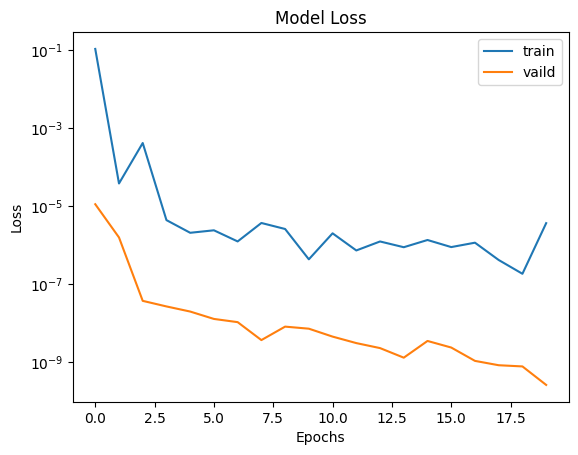

In [6]:
PROJECT.loss_plot()

In [7]:
PROJECT.model.evaluate(PROJECT.X_test)

32/32 [==============================] - 0s 801us/step - loss: 0.0000e+00 - acc: 0.0000e+00


[0.0, 0.0]

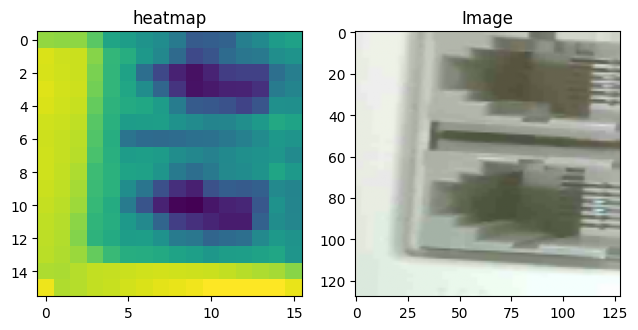

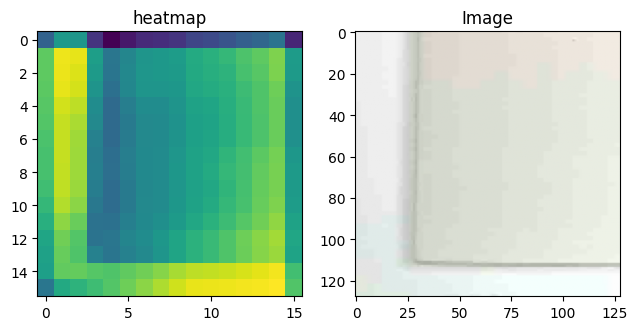

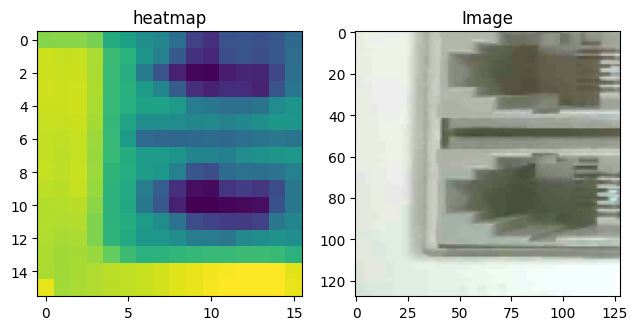

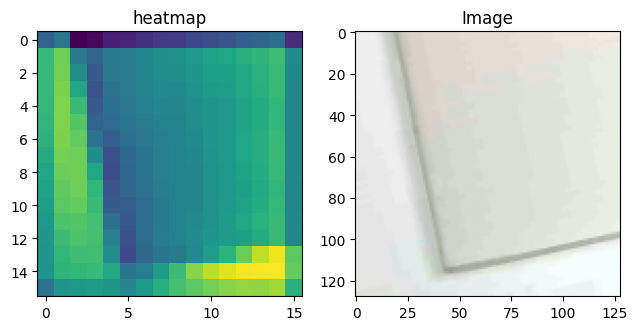

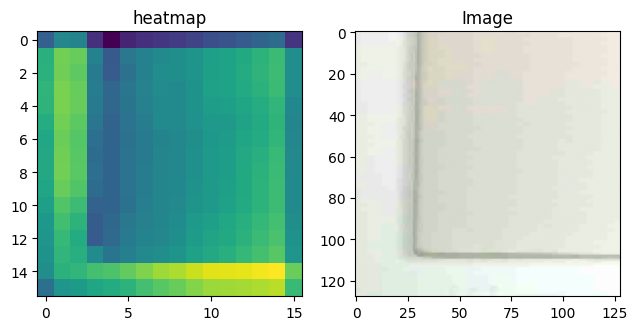

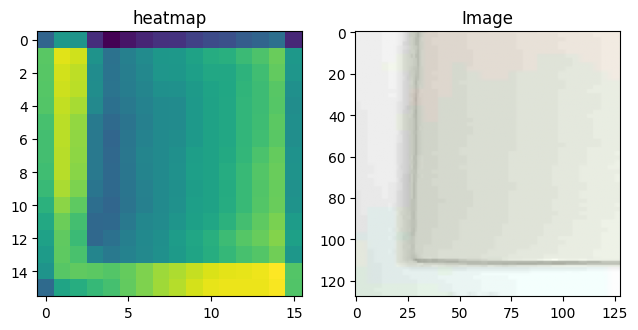

In [11]:
for i in range(54, 60):
    PROJECT.subplot(i)
#PROJECT.subplot(63)

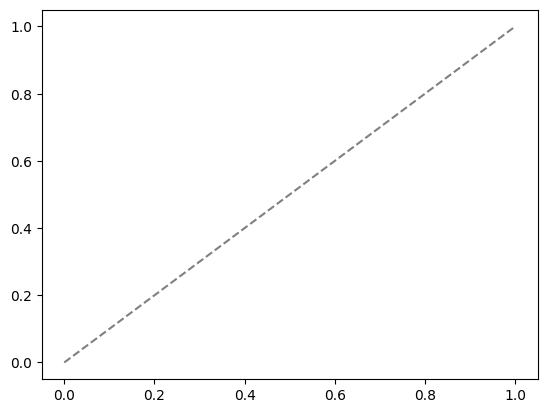

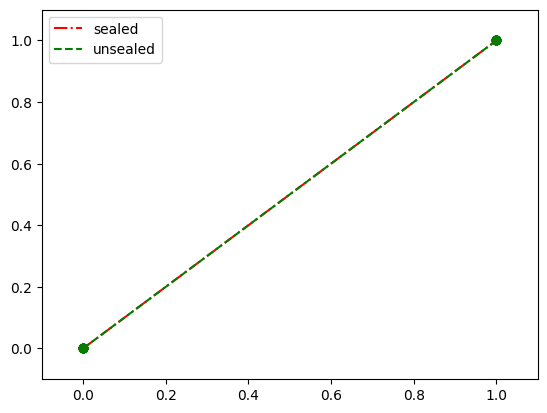

In [9]:
PROJECT.calibration_plot()

In [12]:
# 모델을 저장할 경로와 파일명 지정
model_save_path = './PL_1217_128*128.h5'

# 모델 저장
PROJECT.model.save(model_save_path)
